# **Diffusion Model in Causal Inference with Unmeasured Confounders**
## **Tatsuhiro Shimizu**
## ***AI Lab, CyberAgent Tokyo, Japan***
## **0009-0009-9746-3346**

This is the code for the Example 12. in the main text.
The following image is the SCM that we implement.

- <font color='red'>Unobserved nodes: $X_2$</font>
- Cause node: $X_4$
- Outcome node: $X_6$
- Node that satisfies the backdoor criterion for a pair $(X_4, X_6)$: $X_3$

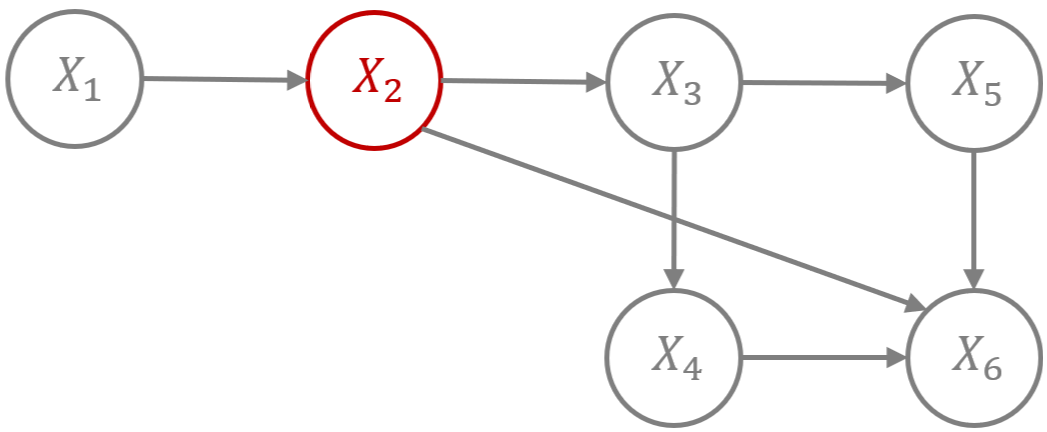

Define
- the number of observation: n_obs = 1000 (same environment as the DCM paper)
- the number of samples from DCM and BDCM: n_sample_DCM = 500 (same environment as the DCM paper)

## DCM Training

Define
- time: $T = 100$
- noise schedule: $\beta_t$ and $\alpha_t$ for all $i = 1, \cdots, T$

- Define
  - the structural equation: $X_i = f(PA(X_i)) + U_i$
    - $X_1 = U_1$
    - $X_2 = X_1^2 + U_2$
    - $X_3 = X_2 + U_3$
    - $X_4 = X_3^2 + X_3 + U_4$
    - $X_5 = X_3^2 + 0.1 + U_5$
    - $X_6 = X_2 X_4 + X_2 X_5 + X_4 X_5 + U_6$
  - number of internvened values
  - intervened values

- Sample
  - exogeneous nodes: $U_1, U_2, U_3, U_4, U_5, U_6 \sim \mathcal{N}(0, 1)$
  - endogenous nodes: $X_1, X_2, X_3, X_4, X_5, X_6$
  - intervened nodes: $X_6|do(X_4 = x_4)$
  - time: $t \sim \mathcal{N}(0, 1)$
  - noise: $\epsilon \sim \mathcal{N}(0, 1)$


  - Define
    - epoch: num_epochs = 500
    - batch size: batch_size = 64
    - learning rate: learning_rate $\eta$ = 0.0001

  - Neural Network: 3 hidden layers
    - 1st layer: 128 nodes
    - 2nd layer: 256 nodes
    - 3rd layer: 256 nodes

  - Train the Neural Network

  - Plot the loss of the training over the epoch

In [1]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import random
import torch
import torch.nn.functional
import torch.utils.data

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

plt.style.use('ggplot')

%matplotlib inline

import conf
from func import set_seed, normalize, DEC, create_array_array_MMD, train_and_plot_neural_net, create_input_1, create_alpha_t_train_for_x
# from sample import sample_array_u
from sample import sample_array_u_and_x, true_sample, sample_t_and_eps_for_x

from nn import MakeDataset, Net_x


/Users/s23599/document/research/Backdoor_DCM/src/func.py:144: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/Users/s23599/document/research/Backdoor_DCM/src/func.py:225: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_1aidzjezue/croot/pytorch_1687856425340/work/torch/csrc/utils/tensor_new.cpp:248.)
  mmd_value = MMD(torch.tensor([normalize(array_array_DCM_BDCM_samples[j][i])]).T.to(device), torch.tensor([normalize(true_sample(d, structural_eq, ind_cause, ind_result, intervened_value_for_cause_node, array_u))[:conf.n_sample_DCM]]).T.to(device), "rbf")


mean of MMD for DCM: 0.00648
standard deviation of MMD for DCM: 0.000404
mean of MMD for BDCM: 0.00534
standard deviation of MMD for BDCM: 0.000157
mean of MMD for DCM: 0.0224
standard deviation of MMD for DCM: 0.017
mean of MMD for BDCM: 0.0201
standard deviation of MMD for BDCM: 0.0123


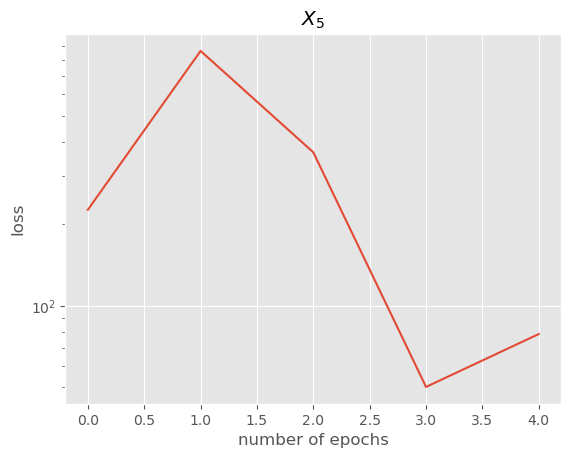

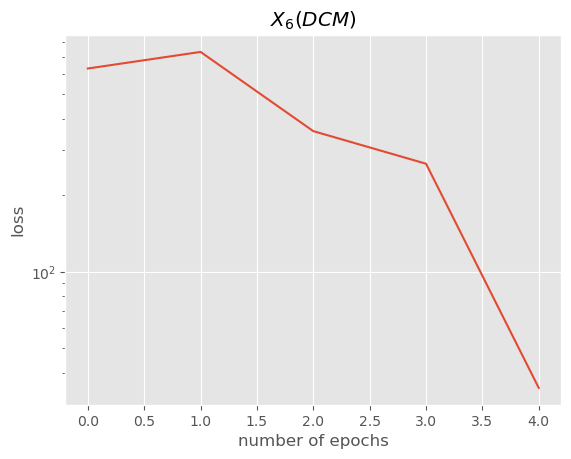

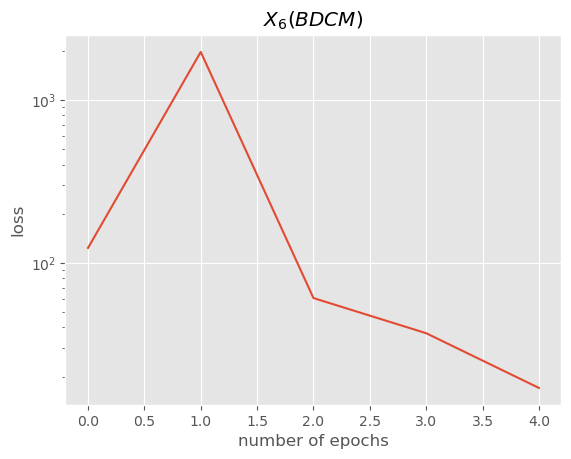

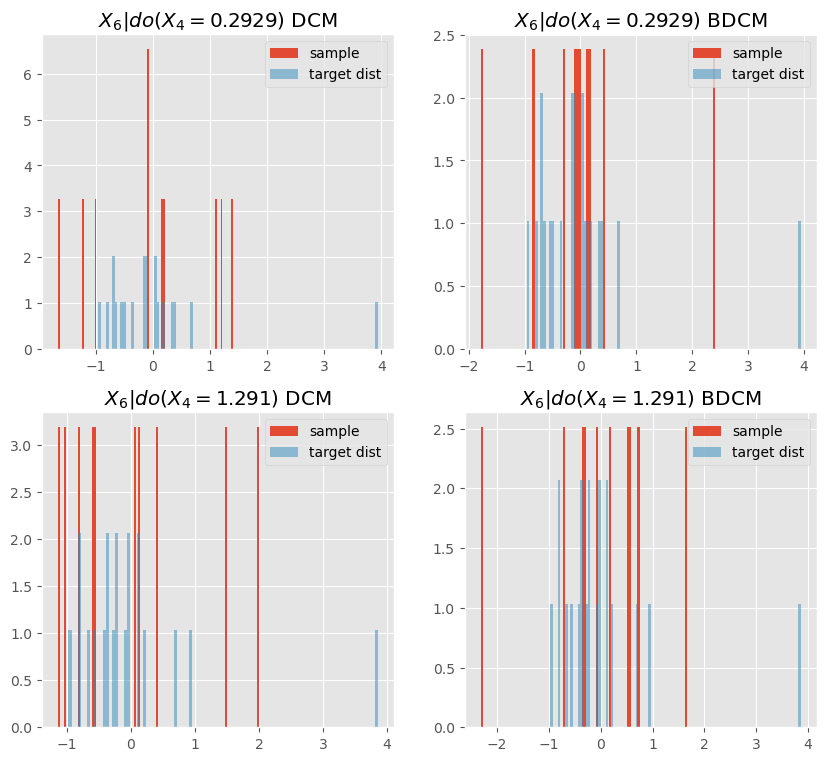

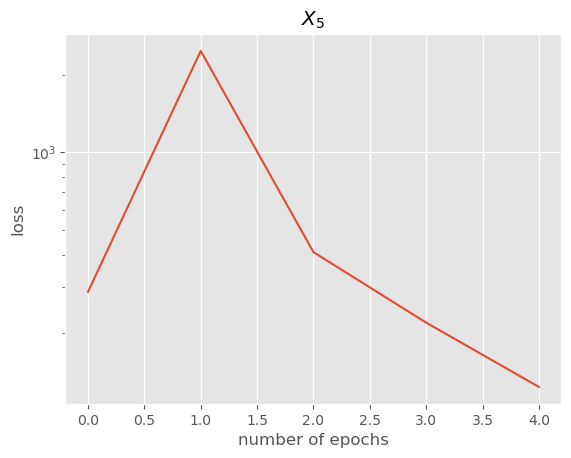

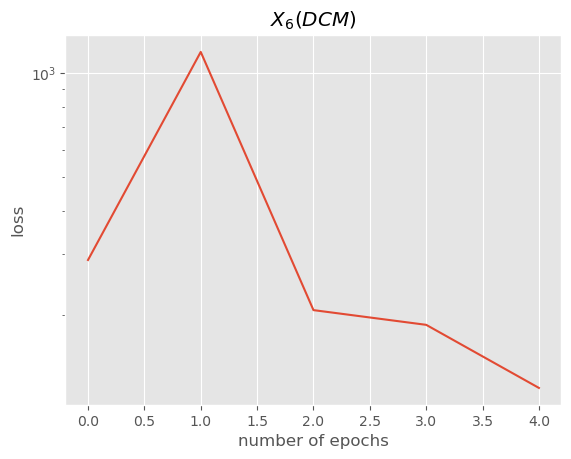

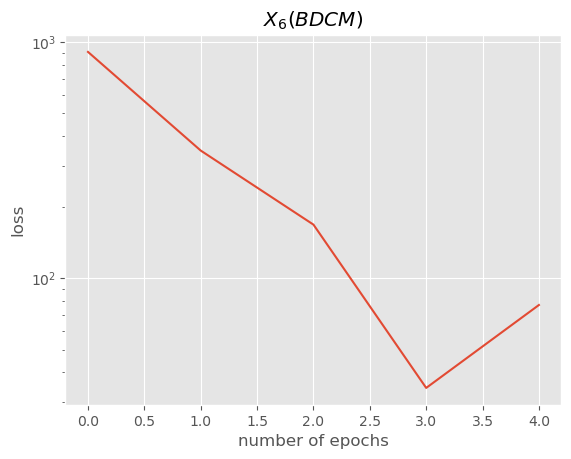

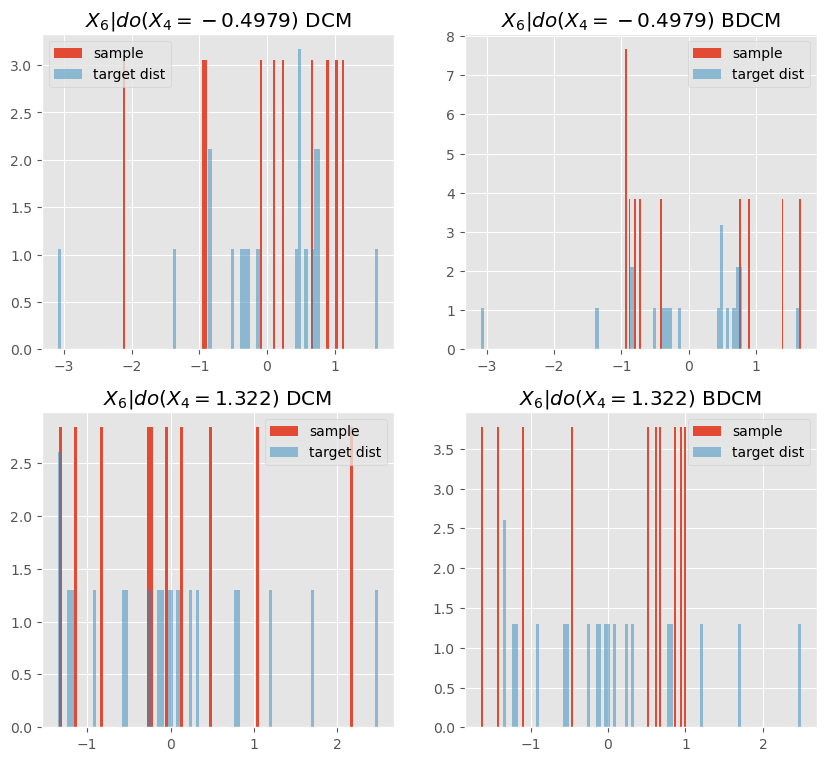

In [2]:
"""# **NEED TO MODIFY HERE**
only d
"""

# Define the number of endogenous or exogenous variables in SCM
d = 6

# index for cause variable X_i = 4
ind_cause = 3

# index for result variable X_i = 6
ind_result = 5

# the array of the list of the indexes of the parent node in DAG
array_list_parent_ind = [[], [1], [2], [3], [3], [2, 4, 5]]

# Define the structual equation
# X_i = f_i(X_{pa_i}) + U_i

def structural_eq(u, ind, x):
  if ind == 0:
    output = u
  elif ind == 1:
    output = x[0] ** 2 + u
  elif ind == 2:
    output = x[1] + u
  elif ind == 3:
    output = x[2] ** 3 + x[2] + u
  elif ind == 4:
    output = x[2] ** 2 + 0.1 + u
  elif ind == 5:
    output = x[1] * x[3] + x[1] * x[4] + x[3] * x[4] + u
  return normalize(output)


# Initialized the array to save the output of each iterations over seeds
array_array_MMD = []
array_title = ["DCM", "BDCM"]

for s in range(conf.num_seeds):
  # Set the seed
  set_seed(s)


  # Define the array of interneved values
  # 10 interventinos with the intervened value ranging from -3 to 3 linearly
  array_interventions = np.random.uniform(conf.lowest_intervention, conf.highest_intervention, conf.num_interventions)

  # # Sample exogenous nodes U_i ~ N(mu, sigma)
  # # Sample endogenous nodes X_i by the structural equations
  array_u, x = sample_array_u_and_x(d, structural_eq)

  # # Generate t ~ Unif([T])
  # # Generate \epsilon ~ N(mu, sigma)
  t_for_x, epsilon_for_x = sample_t_and_eps_for_x(d)

  # # Get the alpha_t for training
  alpha_t_train_for_x = create_alpha_t_train_for_x(d, t_for_x)

  """
  **NEED TO MODIFY HERE**
  """

  # Create the input for the neural network

  # the nodes for which we use DEC
  array_titles = np.array(["X_5", "X_6 (DCM)", "X_6 (BDCM)"])

  # Define the array of the index for epsilon for the neural networks (index - 1)
  array_index_for_epsilon = np.array([4, 5, 5])

  # Define the array of the numbers of the inputs for the neural networks (2 + number of parents or adjustment set)
  array_num_input_for_nn = np.array([3, 4, 4])

  # Define the array of the parents or the adjustment set for each DEC (index - 1)
  parent = [[2], [3, 4], [2, 3]]

  # Define the number of neural network
  num_neural_net = len(array_num_input_for_nn)

  # Initialize the input to be used for the training
  array_input_x = []

  # loop for the number of neural network
  for i in range(num_neural_net):
    # First input by using the predefined function
    ind = array_index_for_epsilon[i]
    fisrt_input = create_input_1(alpha_t_train_for_x[ind], x[ind], epsilon_for_x[ind])
    # Concatenate the inputs
    input_x = np.vstack((fisrt_input, x[parent[i]], t_for_x[ind])).T
    array_input_x.append(input_x)




  # """Train the Neural Network"""
  array_net_x = train_and_plot_neural_net(array_input_x, epsilon_for_x, array_index_for_epsilon, array_num_input_for_nn, array_titles)


  """# **NEED TO MODIFY HERE**


  """

  # Define the function to sample X_4 n times when we intervene to X_1 in DCM
  # Input: the number of samples we want to obtain and the value of the intervention
  # Output: the vector of the samples from the target distribution
  def sample_outcome_do_cause_DCM(x4_intervention):
      # Initialize the sample list by just zero vector
      x_outcome_DDIM_list = np.zeros(conf.n_sample_DCM)

      # Iteratively sample from the target distribution
      for i in range(conf.n_sample_DCM):
          # Sample by the empirical distribution
          x1_sampled = random.choice(x[0])

          # Sample by the empirical distribution
          x3_sampled = random.choice(x[2])

          # Set X_4 to the intervened value
          x4_sampled = x4_intervention

          # Concatenate the parents and nodes which satisfy the backdoor criterion
          x5_parents = np.array([x3_sampled])
          # Sample X_2 by using the decoder function
          x5_sampled = DEC(x5_parents, 0, array_net_x)

          # Concatenate the parents and nodes which satisfy the backdoor criterion
          x6_parents = np.array([x4_sampled, x5_sampled])
          # Sample X_2 by using the decoder function
          x6_sampled = DEC(x6_parents, 1, array_net_x)

          # Add the sampled value to the list
          x_outcome_DDIM_list[i] = x6_sampled

      return x_outcome_DDIM_list

  """# **NEED TO MODIFY HERE**




  """

  # Define the function to sample X_4 n times when we intervene to X_1 in BDCM
  # Input: the number of samples we want to obtain and the value of the intervention
  # Output: the vector of the samples from the target distribution
  def sample_outcome_do_cause_BDCM(x4_intervention):
      # Initialize the sample list by just zero vector
      x_outcome_DDIM_list = np.zeros(conf.n_sample_DCM)

      # Iteratively sample from the target distribution
      for i in range(conf.n_sample_DCM):
          # Sample by the empirical distribution
          x1_sampled = random.choice(x[0])

          # Sample by the empirical distribution
          x3_sampled = random.choice(x[2])

          # Set X_4 to the intervened value
          x4_sampled = x4_intervention

          # Concatenate the parents and nodes which satisfy the backdoor criterion
          x5_parents = np.array([x3_sampled])
          # Sample X_2 by using the decoder function
          x5_sampled = DEC(x5_parents, 0, array_net_x)

          # Concatenate the parents and nodes which satisfy the backdoor criterion
          x6_parents = np.array([x3_sampled, x4_sampled])
          # Sample X_2 by using the decoder function
          x6_sampled = DEC(x6_parents, 2, array_net_x)

          # Add the sampled value to the list
          x_outcome_DDIM_list[i] = x6_sampled

      return x_outcome_DDIM_list

  """# **NEED TO MODIFY HERE**

  """

  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


  # Create the array that save the intervened value, samples from DCM, samples from BDCM
  # Input: array of intervened values
  # Output: DCM and BDCM samples
  def save_array(array_interventions):
    # Get the number of interventions
    num_intervention = np.size(array_interventions)

    # Initialize the array of samples for DCM and BDCM
    array_DCM_samples = np.array([])
    array_BDCM_samples = np.array([])

    # for each intervention
    for i in range(num_intervention):
      if np.any(array_DCM_samples) == False:
        # Plot the empirical distribution of DCM and true target
        array_DCM_samples = np.append(array_DCM_samples, np.array([sample_outcome_do_cause_DCM(array_interventions[i])]))
        # Plot the empirical distribution of BDCM and true target
        array_BDCM_samples = np.append(array_BDCM_samples, np.array([sample_outcome_do_cause_BDCM(array_interventions[i])]))
      else:
        # Plot the empirical distribution of DCM and true target
        array_DCM_samples = np.vstack((array_DCM_samples, np.array([sample_outcome_do_cause_DCM(array_interventions[i])])))
        # Plot the empirical distribution of BDCM and true target
        array_BDCM_samples = np.vstack((array_BDCM_samples, np.array([sample_outcome_do_cause_BDCM(array_interventions[i])])))
      array_array_DCM_BDCM_samples = np.array([array_DCM_samples, array_BDCM_samples])

    return array_array_DCM_BDCM_samples

  # Get the samples from DCM and BDCM
  array_array_DCM_BDCM_samples = save_array(array_interventions)

  """# **NEED TO MODIFY HERE**
  true_sample_x6_do_x4

  intervened_value_for_cause_node
  """

  create_array_array_MMD(array_interventions, array_array_DCM_BDCM_samples, true_sample, d, structural_eq, ind_cause, ind_result, array_u, array_array_MMD)

In [3]:
all_MMD_DCM = np.array([])
all_MMD_BDCM = np.array([])
for i in range(conf.num_seeds):
  all_MMD_DCM = np.append(all_MMD_DCM, array_array_MMD[i][0])
  all_MMD_BDCM = np.append(all_MMD_BDCM, array_array_MMD[i][1])

all_MMD_DCM_BDCM = [all_MMD_DCM, all_MMD_BDCM]
# Output the mean and standard deviation of MMD for DCM and BDCM
# loop for DCM or BDCM
for i in range(2):
    print("mean of all MMD for {}: {:.3}".format(array_title[i], np.mean(all_MMD_DCM_BDCM[i])))
    print("standard deviation of all MMD for {}: {:.3}".format(array_title[i], np.std(all_MMD_DCM_BDCM[i])))


mean of all MMD for DCM: 0.0144
standard deviation of all MMD for DCM: 0.0144
mean of all MMD for BDCM: 0.0127
standard deviation of all MMD for BDCM: 0.0114
